**Christian Gauthier Coursework**
*I worked and submitted alone*

Energy efficiency regression problem to determine the heating load of buildings. Dataset includes 9 predictors and one outcome variable:

X0:  Category of the building

X1: Relative Compactness

X2: Surface Area

X3: Wall Area

X4: Roof Area

X5: Overall Height

X6: Orientation

X7: Glazing Area

X8: Glazing Area Distribution

Y: Heating Load



**Data Inspection And Visualisation**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('data_na.csv')

C:\Users\Christian Gauthier\AppData\Local\Temp\ipykernel_2132\1646168980.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),vmin=-1,vmax=1,cmap="coolwarm",annot=True) #show the data as a heatmap


<AxesSubplot: >

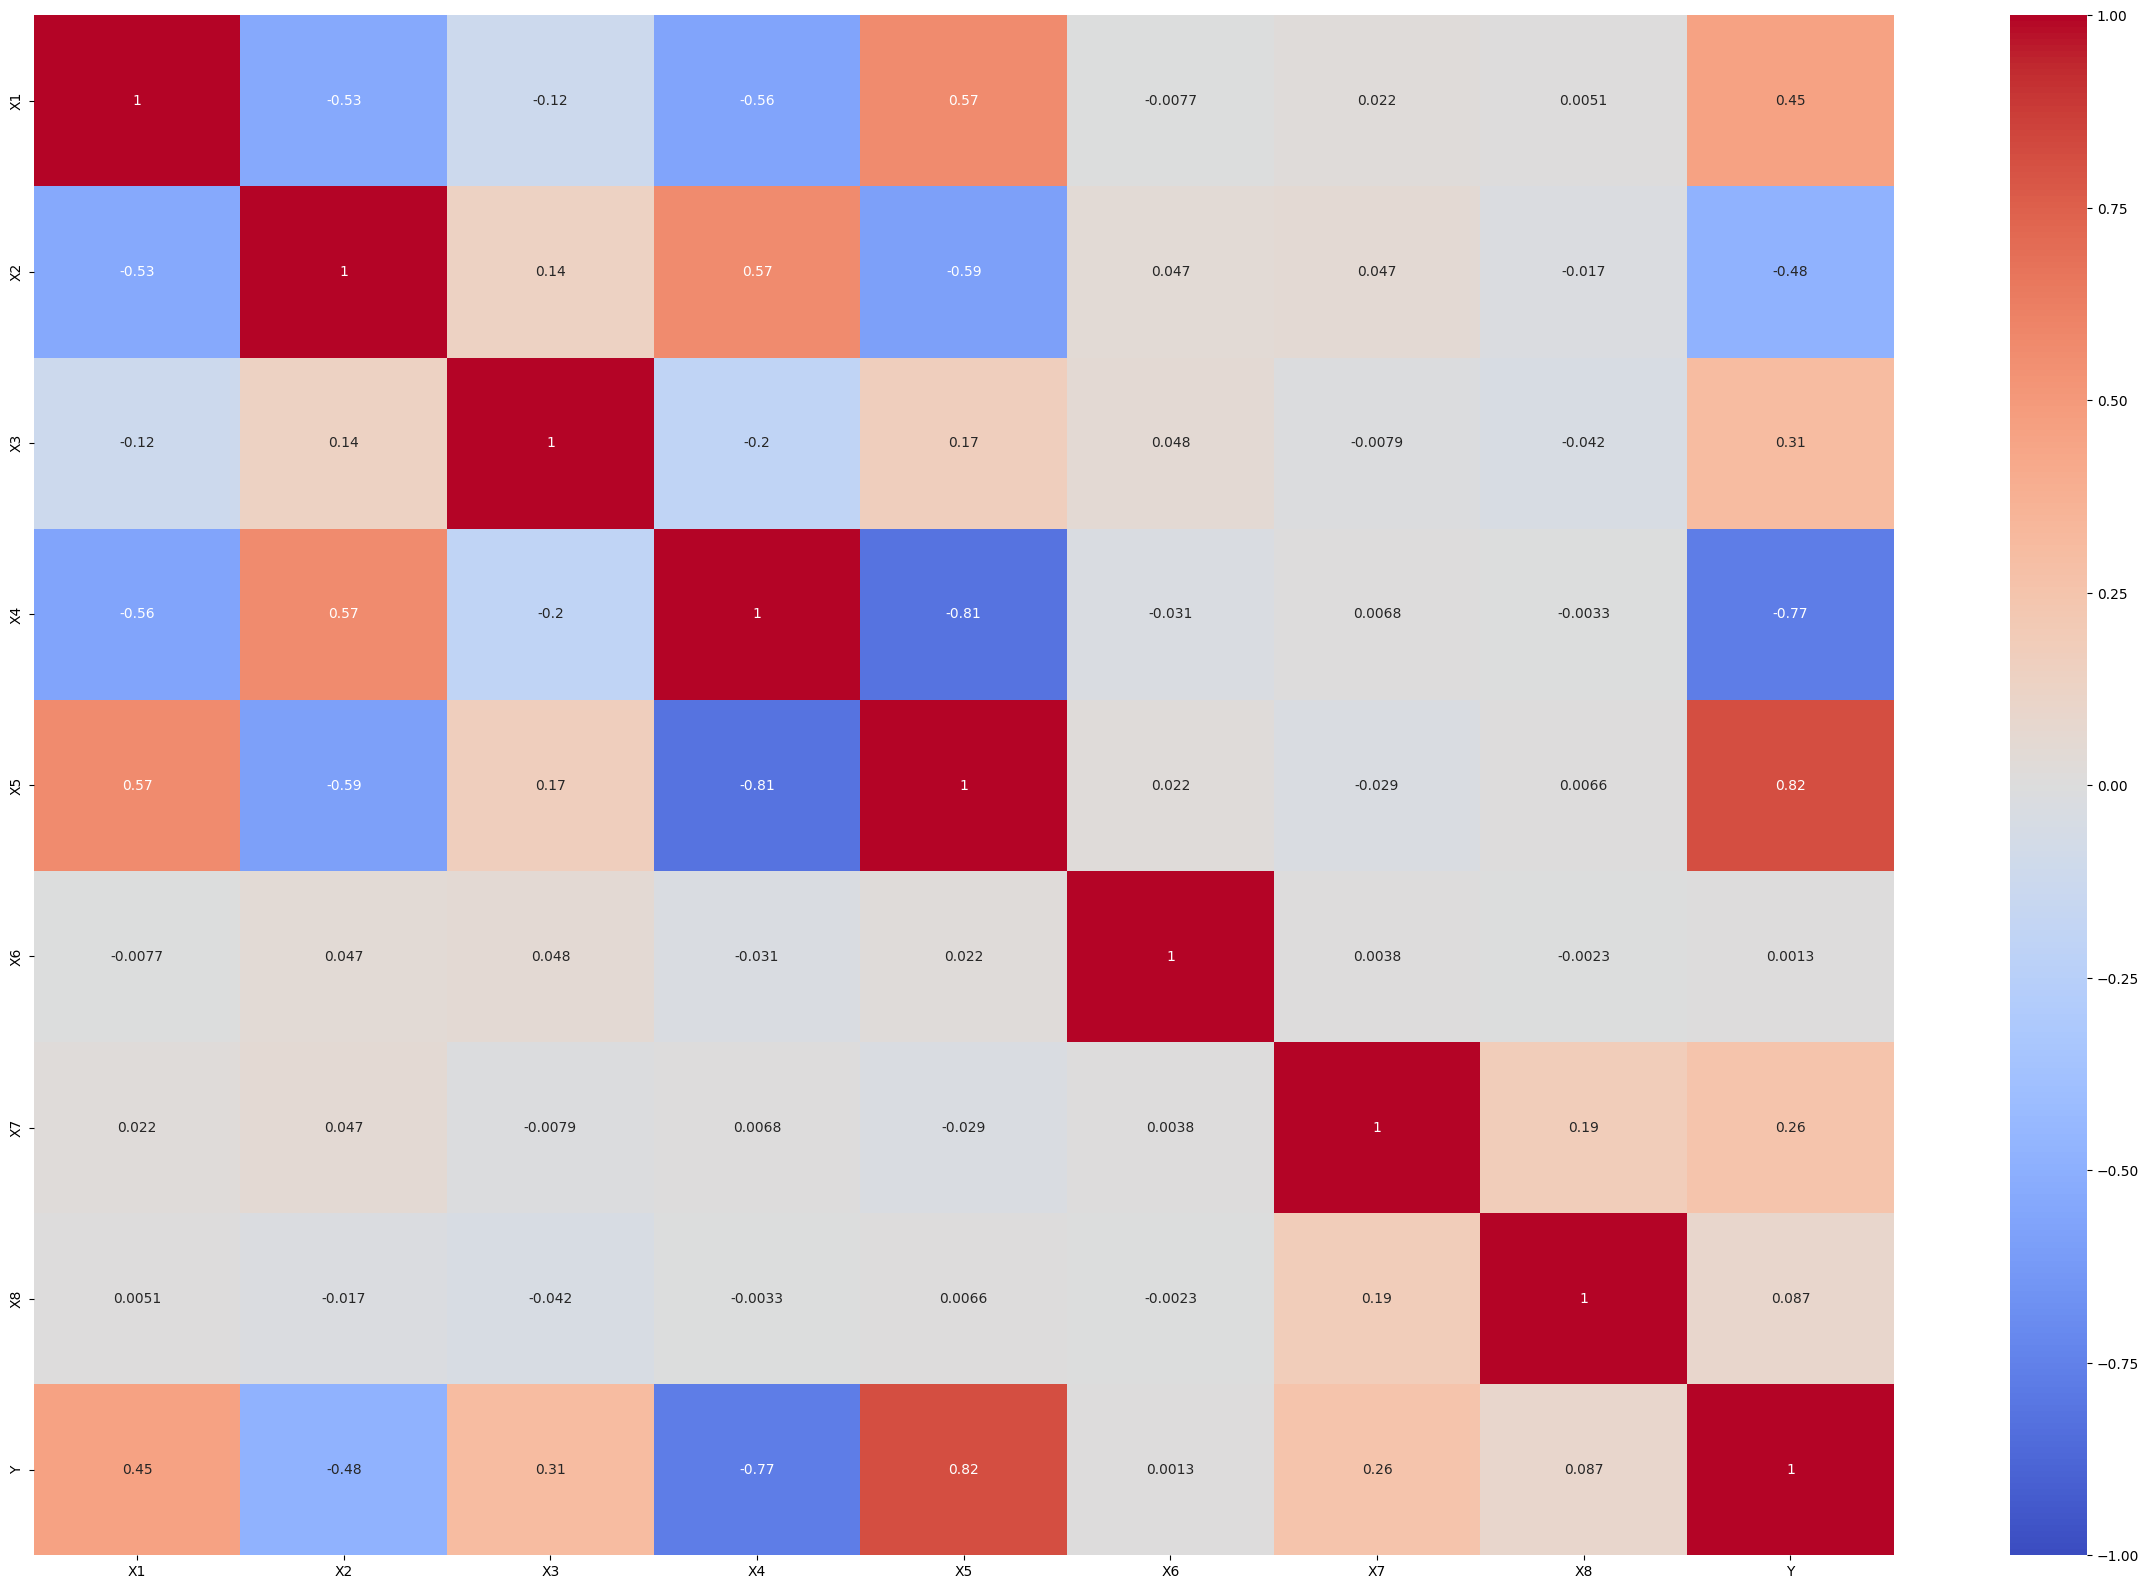

In [2]:
#return a description of the dataframe 
df.describe() 

#create figure of heatmap
plt.figure(figsize=(30,20)) 
sns.heatmap(df.corr(),vmin=-1,vmax=1,cmap="coolwarm",annot=True) #show the data as a heatmap

*Heatmap*

The utilization of a heatmap facilitates the visualization of correlations among variables, thereby displaying the relative significance of predictors with respect to the outcome, namely, the heating load (Y), in an image format. The heatmap analysis allows for the identification of variables that exhibit the highest correlations with the output, with the order of importance being x5, x4, x2, x1, x3, x7, x8, and x6.

array([[<AxesSubplot: title={'center': 'X1'}>,
        <AxesSubplot: title={'center': 'X2'}>,
        <AxesSubplot: title={'center': 'X3'}>],
       [<AxesSubplot: title={'center': 'X4'}>,
        <AxesSubplot: title={'center': 'X5'}>,
        <AxesSubplot: title={'center': 'X6'}>],
       [<AxesSubplot: title={'center': 'X7'}>,
        <AxesSubplot: title={'center': 'X8'}>,
        <AxesSubplot: title={'center': 'Y'}>]], dtype=object)

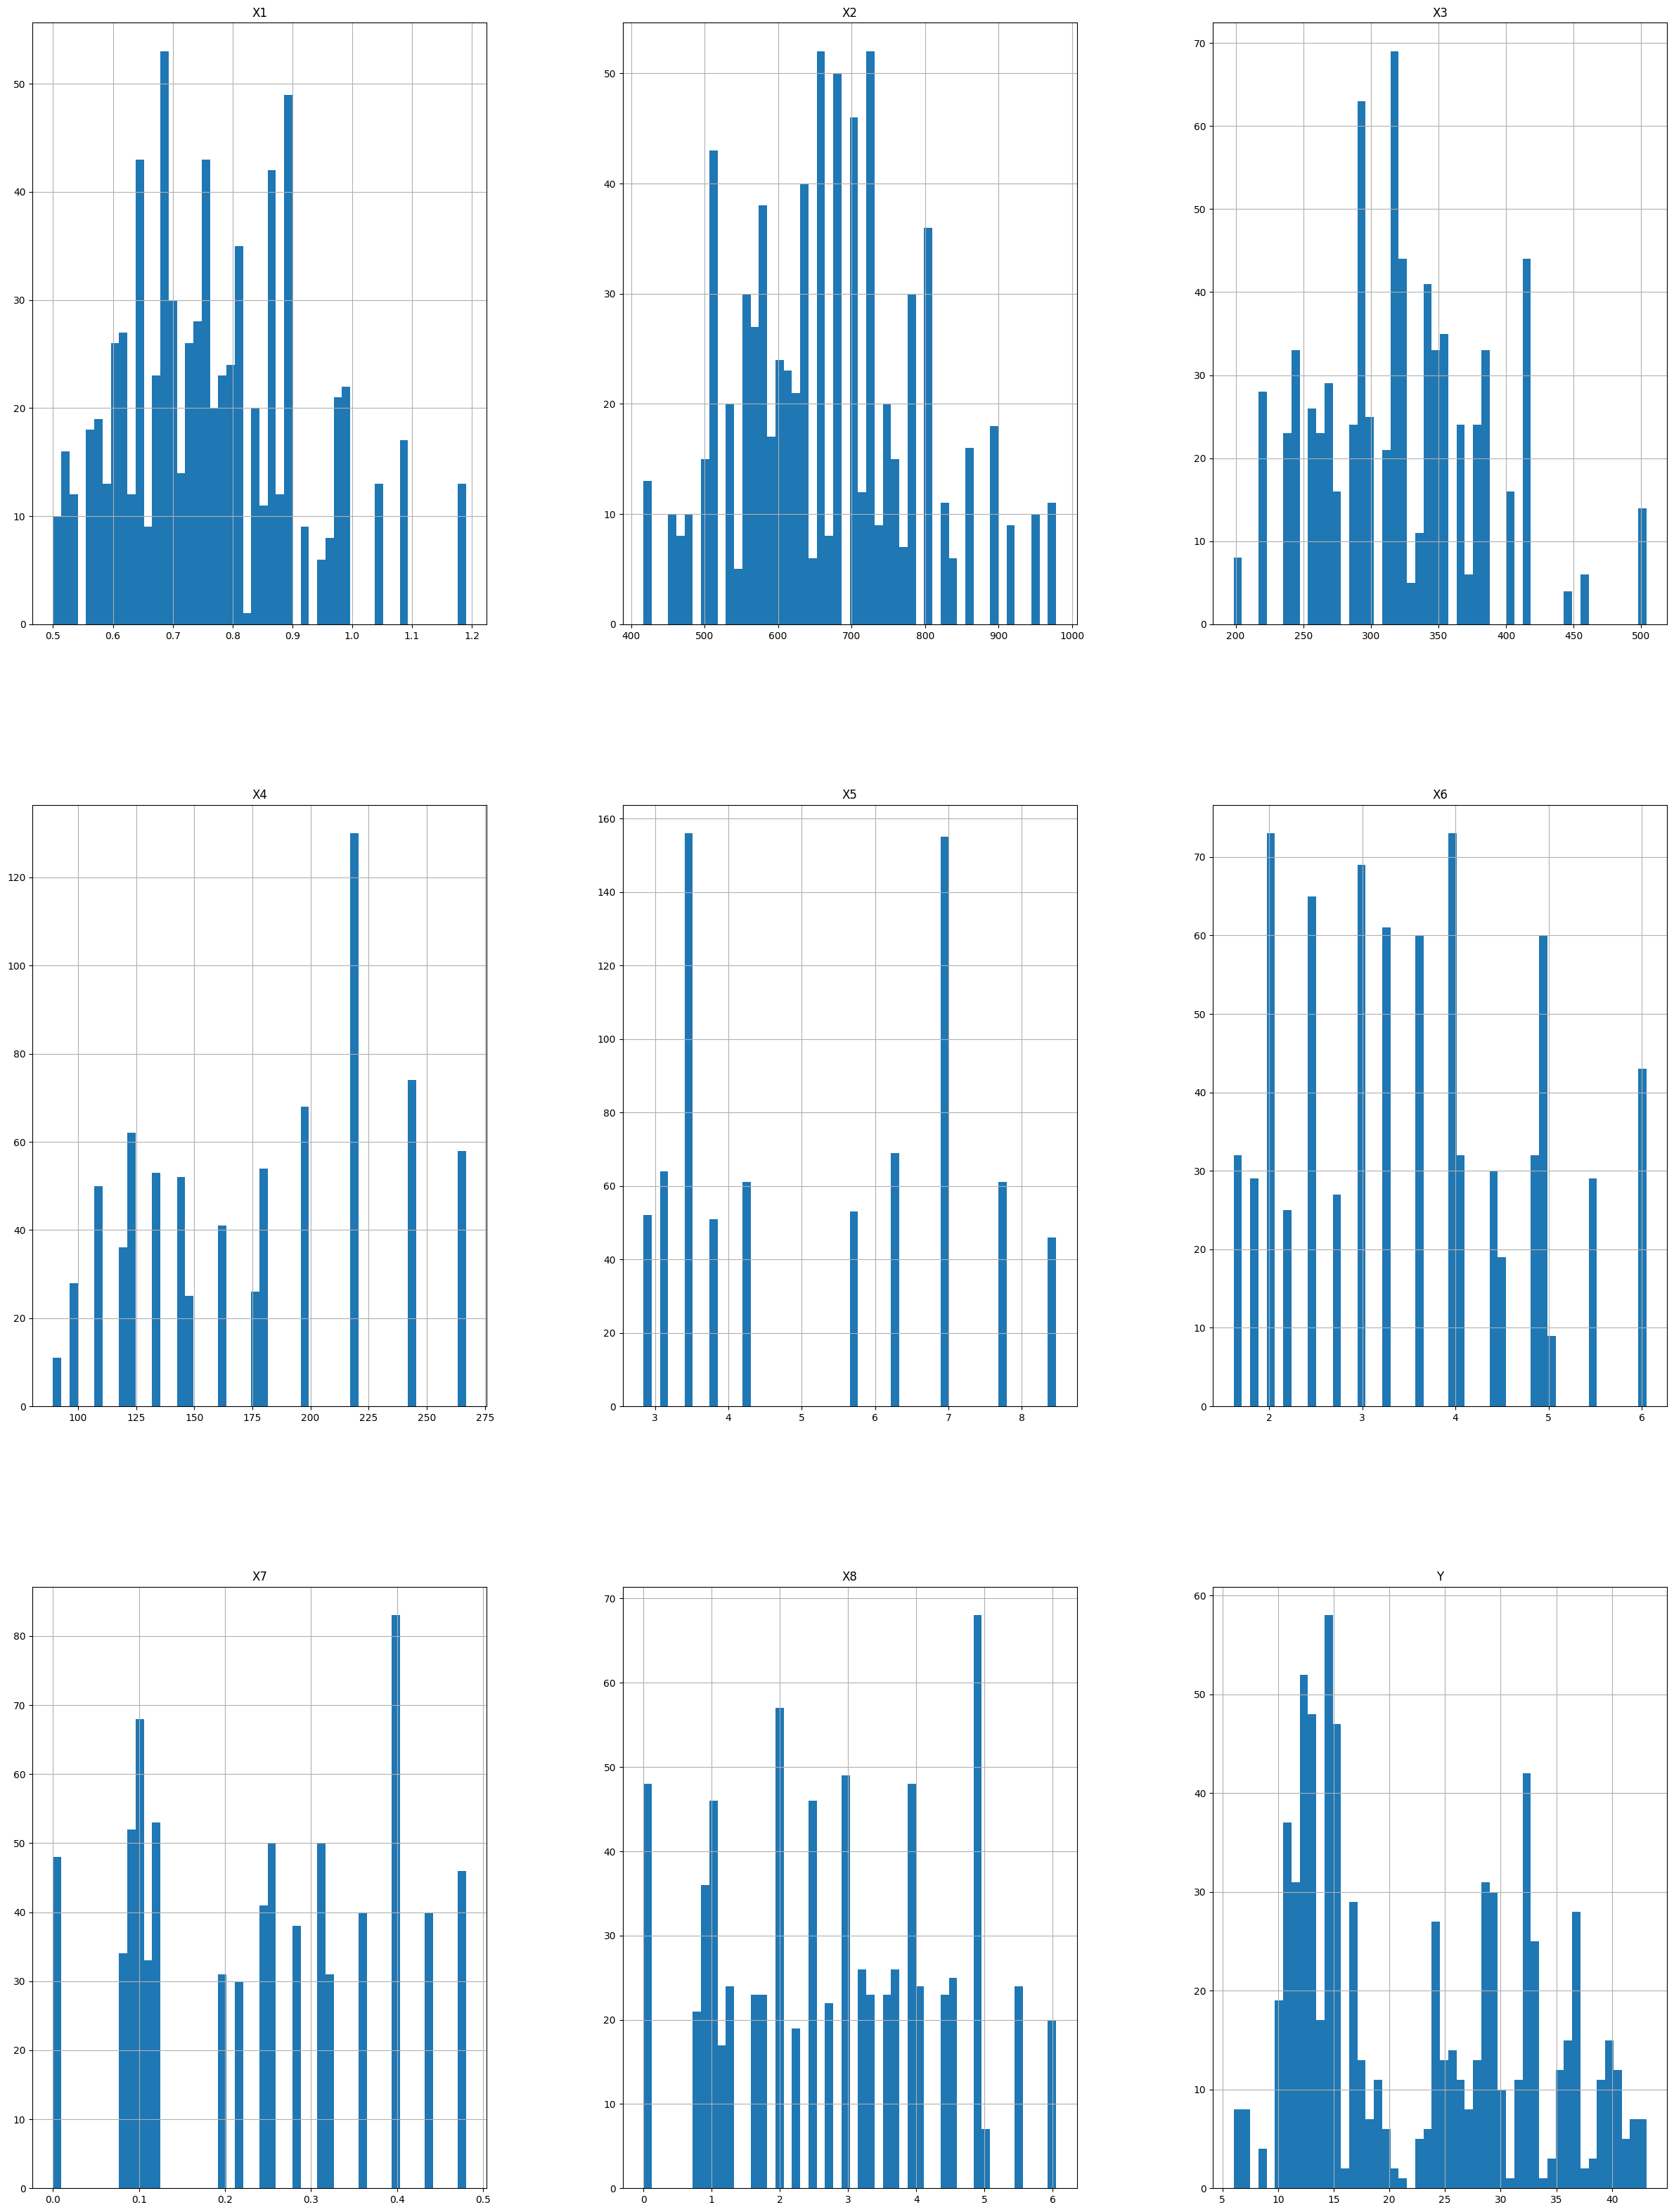

In [3]:
#Histogram plot of dataset
df.hist(bins=50,figsize=(30,40))

*Histogram*

The histogram is a graphical representation that provides insight into the distribution of data for each variable. The analysis of the dataset reveals that only a limited number of variables (X1, X2, X3, and X5) exhibit a clear pattern, with a smooth and easily identifiable distribution compared to the remaining variables. Notably, the distributions indicate the absence of any identifiable outliers that require consideration before use within the models.

**Data Pre-Processing**

In [2]:
#Drop rows conntaining any nan values within columns
df.dropna(inplace=True) 

#Create predictor and label groups from dataset 
labels = df["Y"].copy()
predictors = df.iloc[:, :-1]

In [3]:
print(predictors.iloc[1])
print(labels[1])

X0        C1
X1      0.88
X2    463.05
X3    291.06
X4     99.23
X5      5.67
X6       4.4
X7       0.0
X8       0.0
Name: 2, dtype: object
15.55


In [4]:
#Split the dataset into chunks train/validation/test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(predictors, labels, test_size=0.3, shuffle=False)

In [5]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(509, 9)
(509,)
(219, 9)
(219,)


*Scale the data*

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

#Select numerical features in the predictors
numeric_features = ['X1','X2','X3','X4','X5','X6','X7','X8']
numeric_transformer = Pipeline([
    ('std_scaler', StandardScaler())
])

#Select categorical features
categorical_features = ['X0']
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

#Combine into a column transformation on whole groups within dataset
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

#Apply the transformations based on the train dataset
x_train = preprocessor.fit_transform(x_train)
x_test = preprocessor.transform(x_test)

In [7]:
#Define new standard scaler for Y values
scaler = StandardScaler()

#Reshape the outputs for use in models
y_train = y_train.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)

y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

In [8]:
#Trains have increased by 2 because of the one hot encoding
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(509, 11)
(509, 1)
(219, 11)
(219, 1)


**Model Training And Optimisation**

Now that the data has been processed and is ready for use within the models. The models being used within this study will be Linear Regression, Elastic Net Regression and densely layered Neural Network. Models will be ran through a Kfold validation method in which the average MAE of the models will be used to determine each performance, the models with the lowest values moving to the final stage of having access to the test dataset. 

Hyperparameter tuning will be done via a gridsearch cross-validation method where all parameter configurations are attempted. 

In [9]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from numpy import mean,std,absolute
from sklearn.model_selection import GridSearchCV

def kfolder(modeltype):
    K = 4
    num_val_samples = len(x_train) // K
    all_scores = []
    #Define classifier

    for i in range(K):
        print('processing fold', i)
        
        # Prepare the validation data: data from partition i
        a, b = i * num_val_samples, (i + 1) * num_val_samples
        val_data = x_train[a : b]
        val_targets = y_train[a : b]
        
        # Prepare the training data: data from all other partitions
        partial_train_data = np.concatenate([x_train[:a], x_train[b:]], axis=0)
        partial_train_targets = np.concatenate([y_train[:a], y_train[b:]], axis=0)
        
        
        # Fit the classifier to the training data
        modeltype.fit(partial_train_data, partial_train_targets)

        # Make predictions on the test data
        y_pred = modeltype.predict(val_data)
        all_scores.append(mean_absolute_error(y_pred,val_targets))
    return all_scores

*Linear Regression*

In [10]:
from sklearn.linear_model import LinearRegression

#Define the model
lin_reg = LinearRegression()

#Run model through Kfold
lin_reg_results = kfolder(lin_reg)

#Average score over K-Fold
print('Kfold MAE results: ' + str(lin_reg_results))
print('Mean Kfold MAE: ' + str(np.mean(lin_reg_results)))


processing fold 0
processing fold 1
processing fold 2
processing fold 3
Kfold MAE results: [0.3882803653518926, 0.35458883423756915, 0.3003983260241392, 0.3973877853315112]
Mean Kfold MAE: 0.360163827736278


*Elastic Net*

In [13]:
from sklearn.linear_model import ElasticNet

#define the model
el_net = ElasticNet()

#run the un-tuned model through kfold to see what scores acheived
el_net_results = kfolder(el_net)

#Average score over K-Fold
print('Kfold MAE results: ', el_net_results)
print('Mean Kfold MAE: ', np.mean(el_net_results))

processing fold 0
processing fold 1
processing fold 2
processing fold 3
Kfold MAE results:  [0.7070898035678098, 0.5903286310584337, 0.7237818955883907, 0.7748129840708966]
Mean Kfold MAE:  0.6990033285713827


In [14]:
#Tune the model through the use of a gridsearch to find the best alpha and l1 ratio hyperparams
param_grid = {'alpha': [0.05, 0.1, 0.3, 0.5, 0.75, 0.8, 0.9, 1.0, 2.0, 5.0],
              'l1_ratio': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.45, 0.5, 0.7, 0.9]}

grid_search_el = GridSearchCV(estimator=el_net, param_grid=param_grid, cv=20)
grid_search_el.fit(x_train, y_train)

GridSearchCV(cv=20, estimator=ElasticNet(),
             param_grid={'alpha': [0.05, 0.1, 0.3, 0.5, 0.75, 0.8, 0.9, 1.0,
                                   2.0, 5.0],
                         'l1_ratio': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.45,
                                      0.5, 0.7, 0.9]})

In [15]:
#Best parameter values
print('Best hyperparameters: ', grid_search_el.best_params_)

Best hyperparameters:  {'alpha': 0.05, 'l1_ratio': 0.2}


In [16]:
#Define new model on best params
el_net_best = ElasticNet(alpha=grid_search_el.best_params_['alpha'], l1_ratio=grid_search_el.best_params_['l1_ratio'])

#Run through kfold
el_net_best_results = kfolder(el_net_best)

#Average score over K-Fold
print('Kfold MAE results: ', el_net_best_results)
print('Mean Kfold MAE: ', np.mean(el_net_best_results))

processing fold 0
processing fold 1
processing fold 2
processing fold 3
Kfold MAE results:  [0.3978327551869146, 0.3496386486601927, 0.297646396503466, 0.3967260803905486]
Mean Kfold MAE:  0.36046097018528045


*Dense NN*

In [11]:
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, mean_absolute_error
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

In [37]:
# Define the model
def build_model(learning_rate, momentum, activation, hidden_layer_size, kernel_regularizer):
    model = keras.models.Sequential([
        layers.Dense(hidden_layer_size, activation=activation, input_shape=(x_train.shape[1],), kernel_regularizer=kernel_regularizer),
        layers.Dense(hidden_layer_size, activation=activation, input_shape=(x_train.shape[1],), kernel_regularizer=kernel_regularizer),
        layers.Dense(1)
    ])
    optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate, momentum=momentum)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    return model

In [38]:
#Allow keras model to use scikit-learn estimator
model = KerasRegressor(build_fn=build_model, verbose=0)

C:\Users\Christian Gauthier\AppData\Local\Temp\ipykernel_14748\2623280333.py:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=build_model, verbose=0)


In [39]:
#Define the hyperparamters and what values best to use 
param_grid = {
    'learning_rate': [0.01, 0.015, 0.0175, 0.02, 0.025, 0.03, 0.05],
    'momentum': [0.01, 0.015, 0.0175, 0.02, 0.025, 0.03, 0.05, 0.1],
    'activation': ['relu', 'tanh'],
    'hidden_layer_size': [4, 8, 16, 32, 64],
    'kernel_regularizer': [None, keras.regularizers.l1(0.01), keras.regularizers.l2(0.01)]
}

#Create scoring function 
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

In [40]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=KFold(n_splits=4), scoring=scorer, verbose=1)
grid_search.fit(x_train, y_train)

Fitting 4 folds for each of 1680 candidates, totalling 6720 fits


GridSearchCV(cv=KFold(n_splits=4, random_state=None, shuffle=False),
             estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x00000154850B44F0>,
             param_grid={'activation': ['relu', 'tanh'],
                         'hidden_layer_size': [4, 8, 16, 32, 64],
                         'kernel_regularizer': [None,
                                                <keras.regularizers.L1 object at 0x00000154850B4340>,
                                                <keras.regularizers.L2 object at 0x00000154850B4610>],
                         'learning_rate': [0.01, 0.015, 0.0175, 0.02, 0.025,
                                           0.03, 0.05],
                         'momentum': [0.01, 0.015, 0.0175, 0.02, 0.025, 0.03,
                                      0.05, 0.1]},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False),
             verbose=1)

In [42]:
#Print best parameters
print('Best hyperparameters:', grid_search.best_params_)
print('Best mean absolute error:', np.abs(grid_search.best_score_))

Best hyperparameters: {'activation': 'tanh', 'hidden_layer_size': 8, 'kernel_regularizer': <keras.regularizers.L2 object at 0x00000154850B4610>, 'learning_rate': 0.02, 'momentum': 0.01}
Best mean absolute error: 0.315144438242371


In [43]:
#Function to find best model hyperparams
def best_model():
    model = keras.models.Sequential([
        layers.Dense(8, activation='tanh', input_shape=(x_train.shape[1],), kernel_regularizer=keras.regularizers.l2(0.01)),
        layers.Dense(8, activation='tanh', input_shape=(x_train.shape[1],), kernel_regularizer=keras.regularizers.l2(0.01)),
        layers.Dense(1)
    ])
    optimizer = keras.optimizers.RMSprop(learning_rate=0.02, momentum=0.01)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    return model

In [44]:
#Create new model based on best params
nn_model = best_model()

In [45]:
#run the un-tuned model through kfold to see what scores acheived
nn_results = kfolder(nn_model)

#Average score over K-Fold
print('Kfold MAE results: ', nn_results)
print('Mean Kfold MAE: ', np.mean(nn_results))

processing fold 0
4/4 [==============================] - 0s 3ms/step
processing fold 1
4/4 [==============================] - 0s 2ms/step
processing fold 2
4/4 [==============================] - 0s 1ms/step
processing fold 3
4/4 [==============================] - 0s 2ms/step
Kfold MAE results:  [0.40978632151536143, 0.3301644571727033, 0.2657566338814482, 0.2739495879126098]
Mean Kfold MAE:  0.31991425012053065


**Further Model Selection**

Model Results:

| MODEL      | AVG MAE |
|------------|---------|
| Linear     | 0.3601  |
| Eastic Net | 0.3604  |
| Dense NN   | 0.3199  |

Where possible the models are fit and hyper parameters are tuned through the use of a grid search implementing cross validation. The linear regression model is simply fit and doesnt have any hyper parameter adjustments, however for the elastic net and dense NN the best combinations found are as follows:

Elastic Net: Alpha (How much to multiply pentalty terms): 0.05, L1-Ratio (How much to mix the combination of L1 and L2 Regularization): 0.2 (Meaning more L2 regularization at a 80/20 split)

Dense NN: Activation Function: tanh, Hidden units: 8, Kernel Regularizer: L2, Learning Rate: 0.02, Momentum: 0.01

As can be seen by the results, the linear model and elastic net model had very similar results with only a 0.003 difference whilst the dense NN had had a higher performance with an average MAE of 0.3208 (improvement of 0.0402). Going into the final evaluation on the test set, the Linear and Dense NN models will be used

**Linear Regression Results**

In [46]:
from sklearn import metrics

#Get model predictions
y_pred_lin_reg = lin_reg.predict(x_test)
y_pred_lin_reg_inverse = scaler.inverse_transform(y_pred_lin_reg)

#Invert the scaled values
y_test_inverse = scaler.inverse_transform(y_test)

lin_result = pd.DataFrame({'Actual': y_test_inverse.flatten(), 'Predicted': y_pred_lin_reg_inverse.flatten()})
print(lin_result)

     Actual  Predicted
0     31.89  38.136616
1     32.39  30.105216
2     32.09  28.872324
3     31.29  31.678075
4     29.22  38.098616
..      ...        ...
214   18.16  21.431775
215   17.88  23.717094
216   16.44  26.144749
217   16.48  20.754976
218   16.64  20.200670

[219 rows x 2 columns]


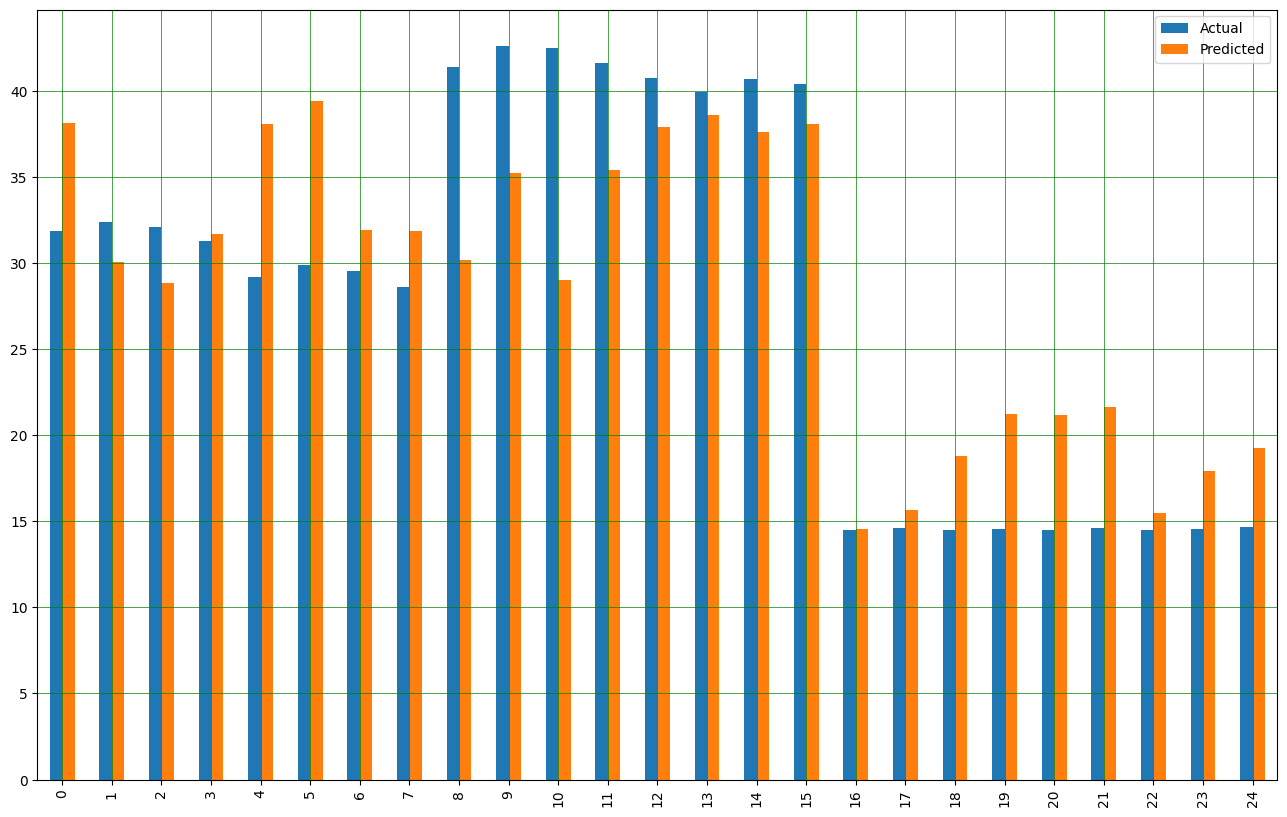

In [47]:
#Plot results
plot_lin_results = lin_result.head(25)
plot_lin_results.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [48]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_lin_reg))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_lin_reg))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_lin_reg)))

Mean Absolute Error: 0.4727570864949168
Mean Squared Error: 0.3250572836884583
Root Mean Squared Error: 0.5701379514542584


**Dense NN Results**

In [51]:
#Get model predictions
y_pred_nn = nn_model.predict(x_test)
y_pred_nn_inverse = scaler.inverse_transform(y_pred_nn)


nn_results = pd.DataFrame({'Actual': y_test_inverse.flatten(), 'Predicted': y_pred_nn_inverse.flatten()})
print(nn_results)

7/7 [==============================] - 0s 2ms/step
     Actual  Predicted
0     31.89  33.673733
1     32.39  33.072567
2     32.09  31.357031
3     31.29  33.705894
4     29.22  34.754955
..      ...        ...
214   18.16  18.015121
215   17.88  18.470303
216   16.44  21.641262
217   16.48  17.729095
218   16.64  17.758257

[219 rows x 2 columns]


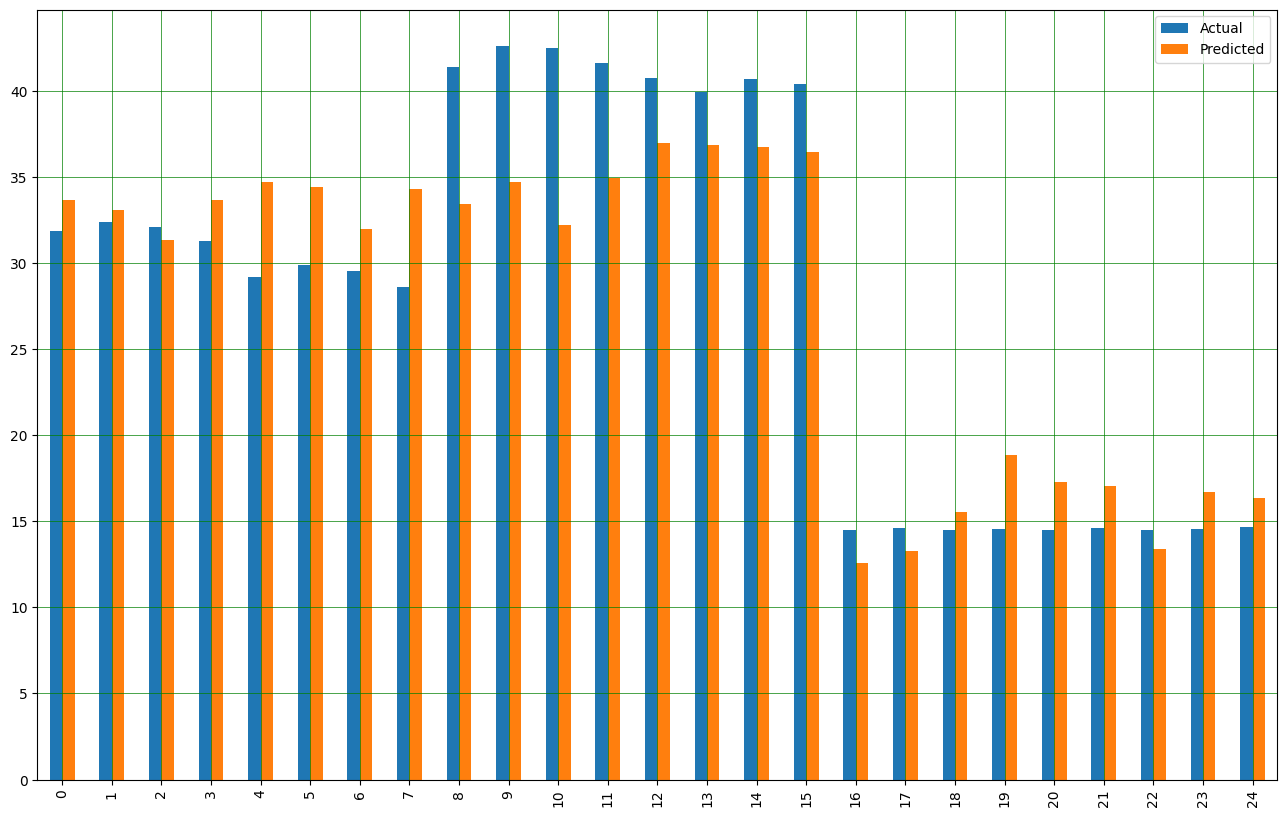

In [52]:
#Plot results
plot_nn_results = nn_results.head(25)
plot_nn_results.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [53]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_nn))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_nn))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_nn)))

Mean Absolute Error: 0.31798583235304034
Mean Squared Error: 0.1623134167056024
Root Mean Squared Error: 0.4028813928510504


**Evaluation**

| MODEL    | AVG MAE | AVG MSE | AVG RMAE |
|----------|---------|---------|----------|
| Linear   | 0.4727  | 0.3250  | 0.5701   |
| Dense NN | 0.3179  | 0.1623  | 0.4028   |

We can see that overall the dense neural network performed better at predicting the heating load on unseen test data compared to the linear model. The average MAE of the dense model was 0.3179, which was 0.1548 lower than the linear model's average MAE of 0.4727. The dense model's average MSE was also lower at 0.1623 compared to the linear model's average MSE of 0.3250. Additionally, the average RMAE for the dense model was 0.4028, indicating an overall better performance compared to the linear model's RMAE of 0.5701. 